# **Seminar 1:** Introduction to Multimodal Models

Multimodal models can be classified in two types based on the fusion of input modalities:

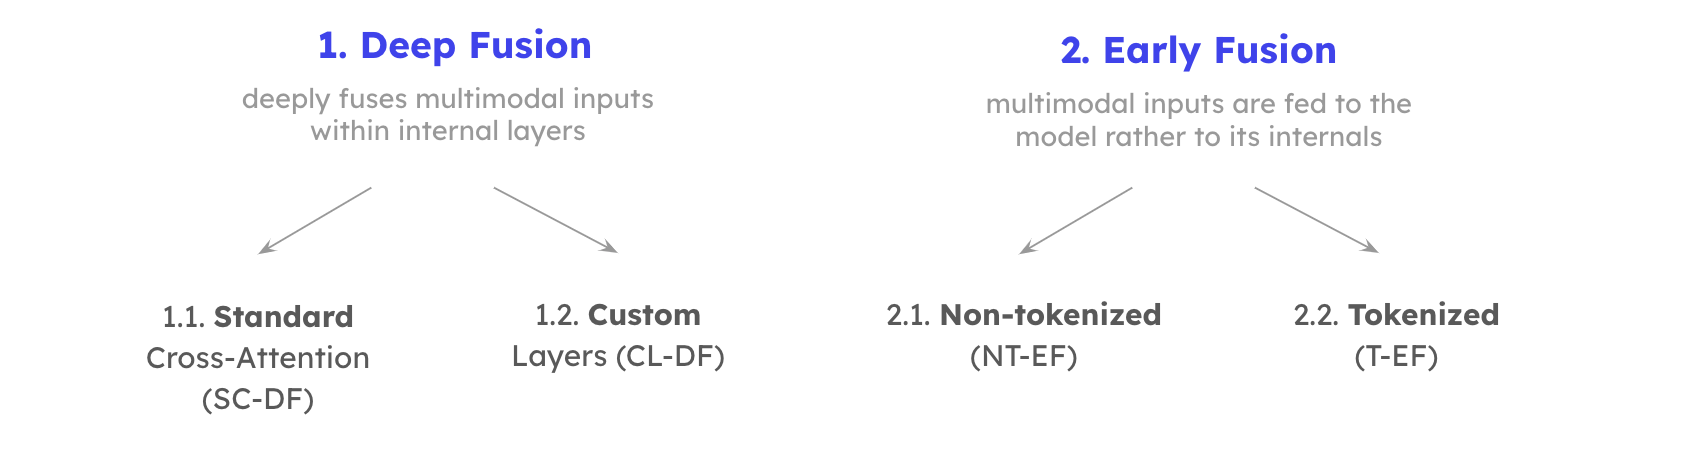


## 1. **Deep Fusion**

### 1.1. Deep Fusion: Standard Cross-Attention (SCDF)



#### **Flamingo family:** OpenFlamingo ([GitHub](https://github.com/mlfoundations/open_flamingo), [Paper](https://arxiv.org/abs/2308.01390))

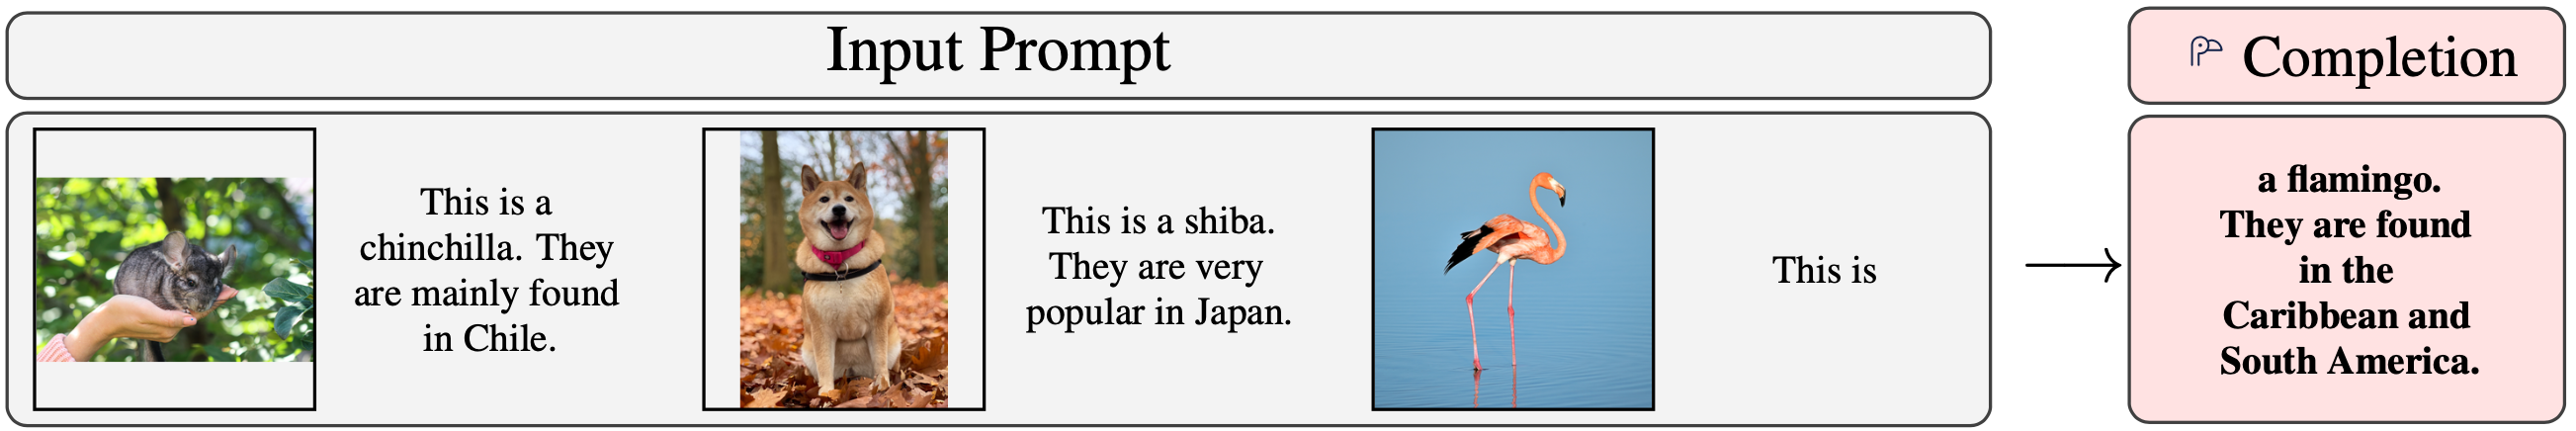

##### **Inference:** Few-shot learning capabilities

Can't be launched in Google Colab due to small RAM capacity (~13 GB). Therefore, we choose Kaggle with 29 GB of RAM.

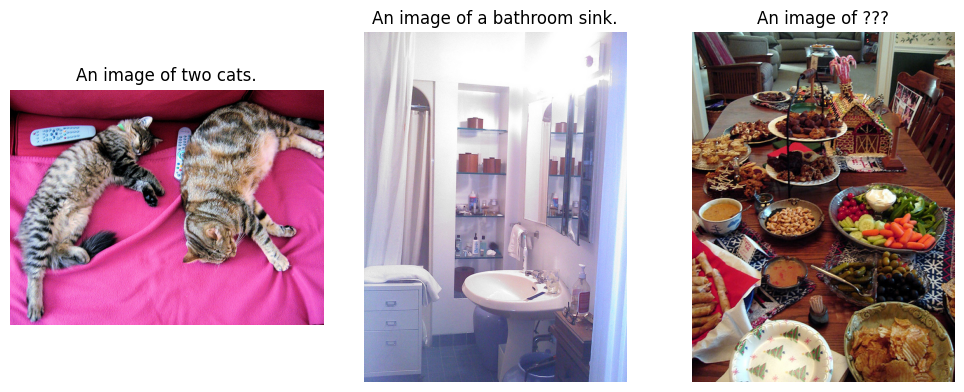

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests


def load_image(url):
    response = requests.get(url, stream=True)
    return Image.open(response.raw)


def plot_images(images, titles, figsize=(10, 4)):
    """Plot images in a row with corresponding titles."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


image_urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",
    "http://images.cocodataset.org/test-stuff2017/000000028137.jpg",
    "http://images.cocodataset.org/test-stuff2017/000000028352.jpg"
]

titles = ['An image of two cats.', 'An image of a bathroom sink.', 'An image of ???']
images = [load_image(url) for url in image_urls]

plot_images(images, titles)

In [ ]:
!pip install open-flamingo[eval]

In [ ]:
from open_flamingo import create_model_and_transforms
from huggingface_hub import hf_hub_download
import torch

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",                  # vision encoder
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",  # LLM
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
    cross_attn_every_n_layers=1,
)

# load model checkpoint
checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-3B-vitl-mpt1b", "checkpoint.pt")   # MLLM weights
model.load_state_dict(torch.load(checkpoint_path), strict=False)

After model loading there could be an issue with Incompatable keys (although we set strict=False). In such situations, first of all it can be very useful to explore **GitHub issues** :)

"Note that the checkpoint only contains weights for parameters we train in OpenFlamingo, so torch will still print some IncompatibleKeys information after loading. So long as those incompatible keys **do not include** perceiver or lang_encoder.transformer.blocks[0].gated_cross_attn_layer weights, you should be good!"

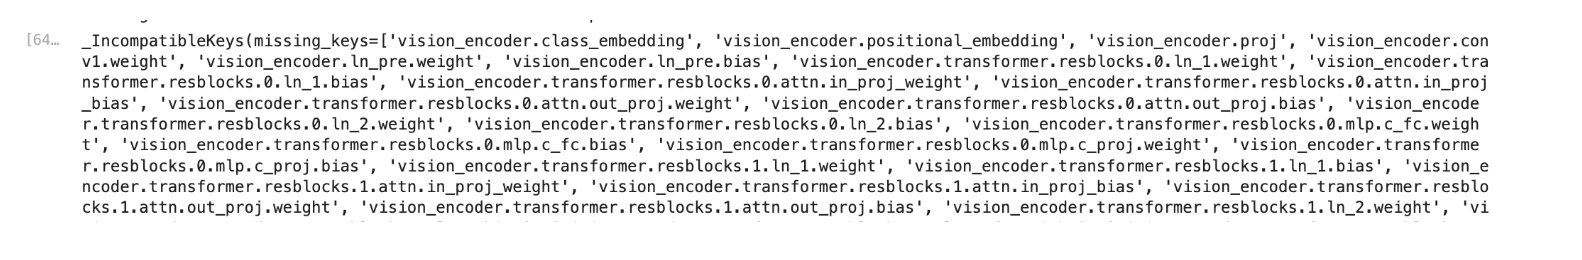

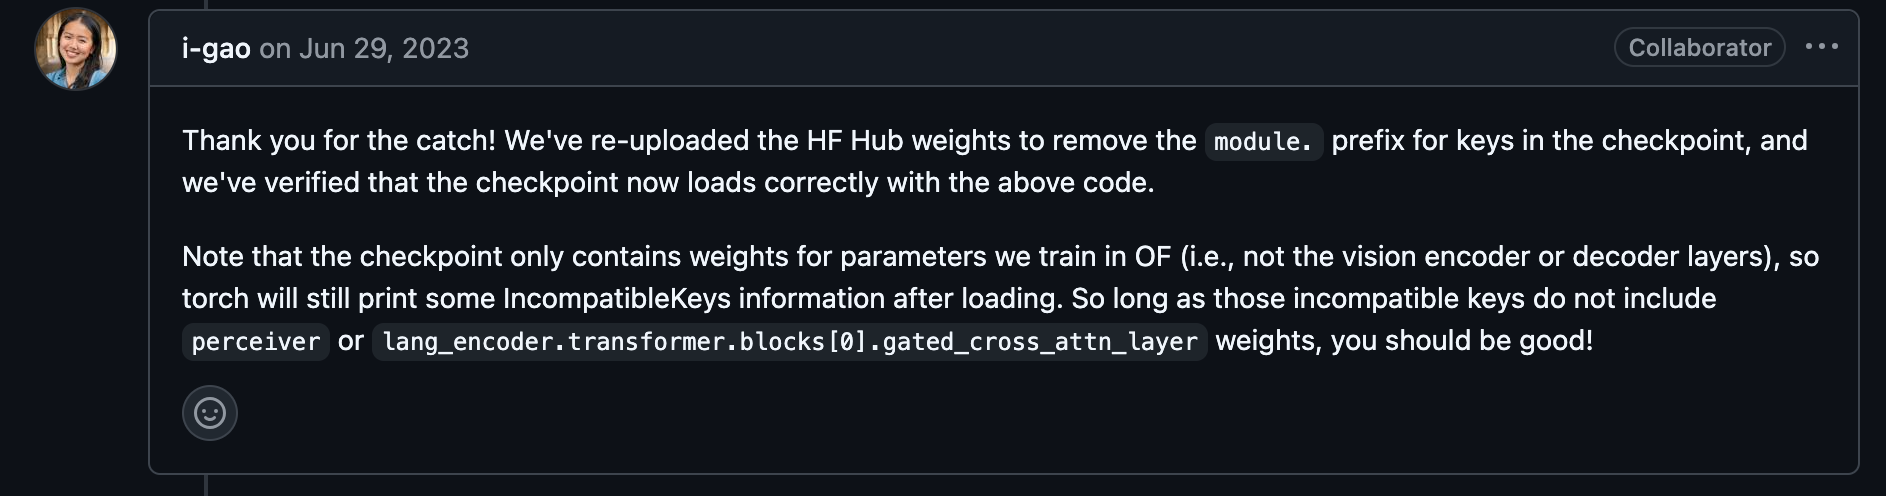

In [ ]:
"""
Step 2: Preprocessing images
Details: For OpenFlamingo, we expect the image to be a torch tensor of shape
 batch_size x num_media (=t_img) x num_frames x channels x height x width.
 In this case batch_size = 1, num_media = 3, num_frames = 1,
 channels = 3, height = 224, width = 224.
"""
vision_x = [image_processor(image).unsqueeze(0) for image in images]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)


"""
Step 3: Preprocessing text
Details: In the text we expect an <image> special token to indicate where an image is.
 We also expect an <|endofchunk|> special token to indicate the end of the text
 portion associated with an image.
"""
tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of"],
    return_tensors="pt",
)


"""
Step 4: Generate text
"""
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)

GPT-like models does not have dedicated <PAD> token:

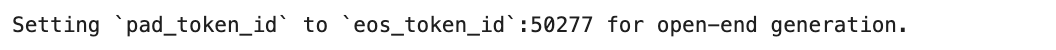

In [ ]:
image_processor(images[0]).unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [ ]:
lang_x

{'input_ids': tensor([[50278,  1145,  2460,   273,   767, 16581,    15, 50277, 50278,  1145,
          2460,   273,   247, 15336, 16338,    15, 50277, 50278,  1145,  2460,
           273]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
generated_text

tensor([[50278,  1145,  2460,   273,   767, 16581,    15, 50277, 50278,  1145,
          2460,   273,   247, 15336, 16338,    15, 50277, 50278,  1145,  2460,
           273,   247,  9449, 14664,   292,    15, 50277]])

In [ ]:
def extract_text_before_last_tokens(text, image_token="<image>", end_token="<|endofchunk|>"):
    start_index = text.rfind(image_token) + len(image_token)
    last_index = text.rfind(end_token)
    return text[start_index:last_index].strip()


text = tokenizer.decode(generated_text[0])
result = extract_text_before_last_tokens(text)
print(result)

An image of a Christmas buffet.


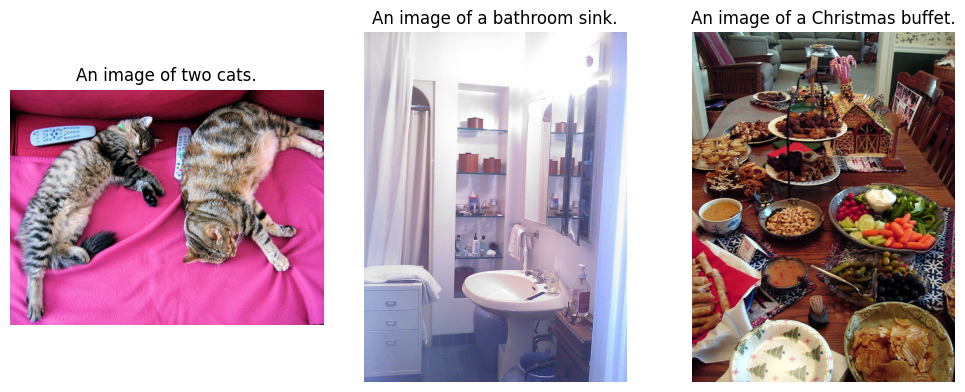

In [ ]:
titles[2] = result
plot_images(images, titles)

##### **Model Architecture** ([GitHub](https://github.com/mlfoundations/open_flamingo))

Key components:

1. Perceiver Resampler
2. Feature Fusion via cross-attention

<img src="attachment:4e128a81-dc6a-4346-a149-6fb1f22e85b0.png" width=800>

In [ ]:
import torch
from torch import nn
# from .helpers import PerceiverResampler


'''
open_flamingo/src/flamingo.py
'''


class Flamingo(nn.Module):
    def __init__(
        self,
        vision_encoder: nn.Module,
        lang_encoder: nn.Module,
        eoc_token_id: int,
        media_token_id: int,
        vis_dim: int,
        cross_attn_every_n_layers: int = 1,
        gradient_checkpointing: bool = False,
    ):
        super().__init__()
        self.eoc_token_id = eoc_token_id          # Token id for <|endofchunk|>
        self.media_token_id = media_token_id      # Token id for <image>
        self.vis_dim = vis_dim                    # Dimension of the visual features
        if hasattr(lang_encoder.config, "d_model"):
            self.lang_dim = lang_encoder.config.d_model
        else:
            self.lang_dim = lang_encoder.config.hidden_size

        self.vision_encoder = vision_encoder.visual             # CLIPModel
        self.perceiver = PerceiverResampler(dim=self.vis_dim)   # here our Perceiver is initialized!
        self.lang_encoder = lang_encoder
        self.lang_encoder.init_flamingo(
            media_token_id=media_token_id,
            lang_hidden_size=self.lang_dim,
            vis_hidden_size=self.vis_dim,
            cross_attn_every_n_layers=cross_attn_every_n_layers,
            gradient_checkpointing=gradient_checkpointing,
        )
        self._use_gradient_checkpointing = gradient_checkpointing
        self.perceiver._use_gradient_checkpointing = gradient_checkpointing

**1. Perceiver Resampler**

Connects the vision encoder to the frozen language model

* Takes as input a variable number of image features and produces a fixed number of visual outputs (64)
* **Reduces the computational complexity** of the vision-text cross-attention


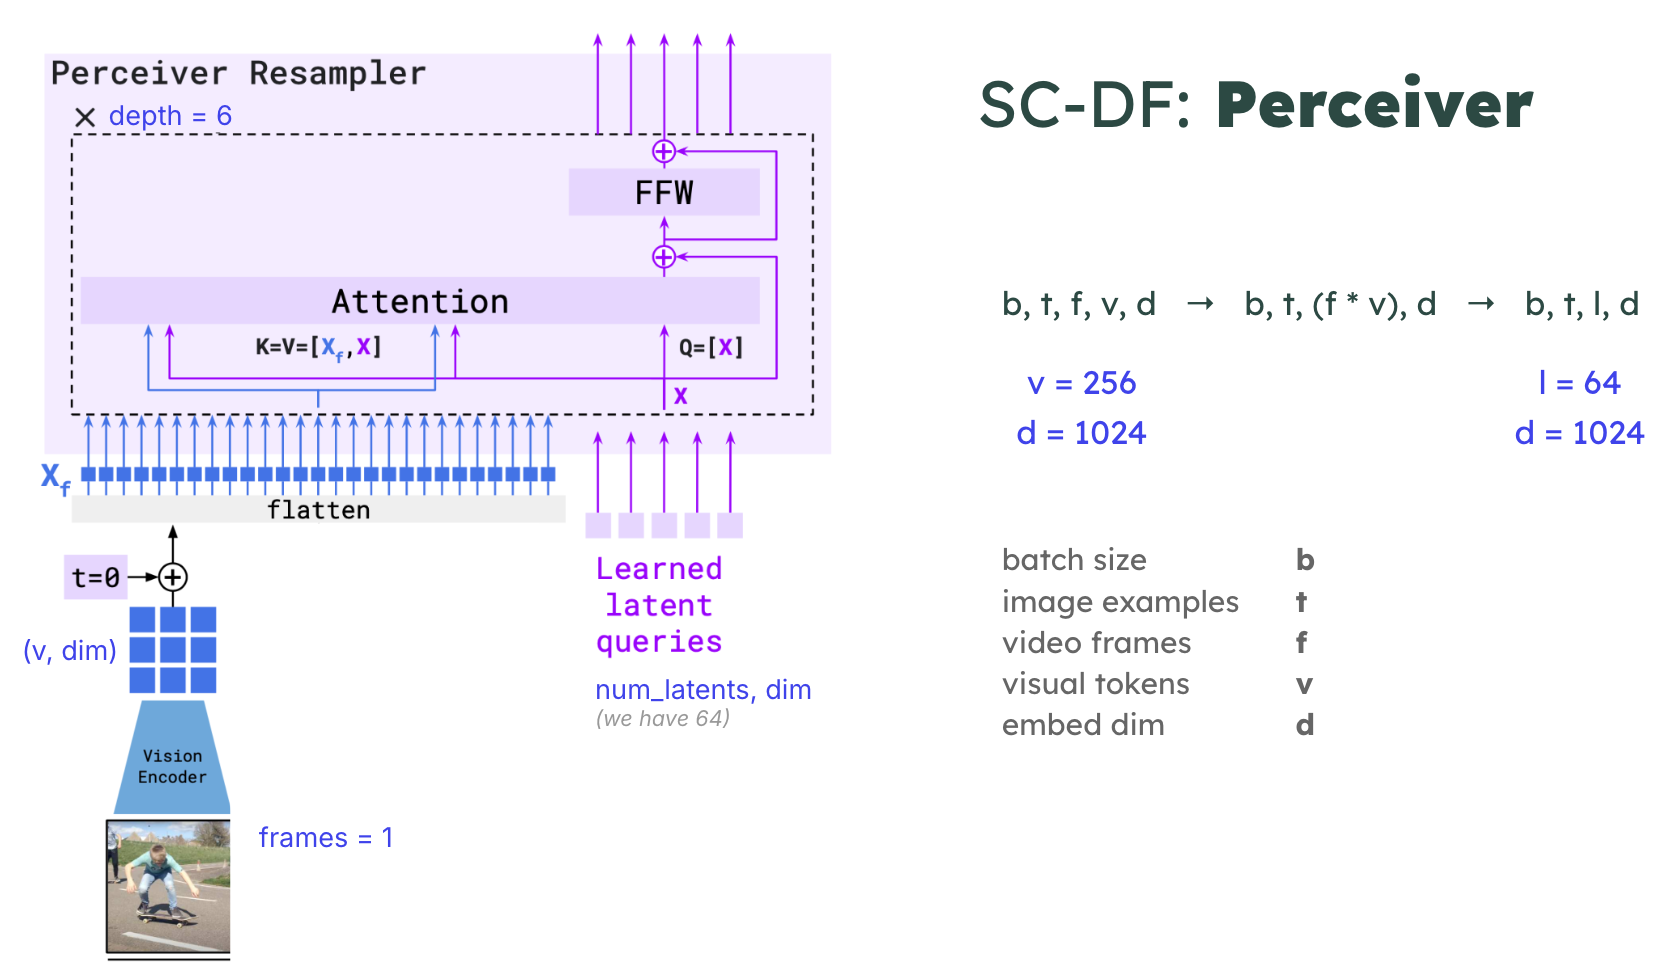

In [1]:
%pip install einops-exts

In [ ]:
'''
Image is processed using visual encoder and Perceiver entity to obtain fixed number of visual tokens.
open_flamingo/src/flamingo.py -- def _encode_vision_x(self, vision_x: torch.Tensor)
'''

# obtain image features through visual encoder CLIP ViT-L/14

batch_size = 2          # 2 separate conversations
t_img = 3               # 3 images per conversation
frames = 1              # OpenFlamingo does not support video, so only one frame
channels = 3            # RGB
height = width = 224    # Standard CLIP input size


vision_x = torch.rand(batch_size, t_img, frames, channels, height, width)
print(f"Input shape: {vision_x.shape}")  # (b, t, F, c, h, w)

Input shape: torch.Size([2, 3, 1, 3, 224, 224])


In [ ]:
from transformers import CLIPVisionModel

vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")

In [ ]:
# Step 1: Rearrange for CLIP processing
# Flatten batch, images per conversation, and frames dimensions

vision_x_flat = rearrange(vision_x, "b T F c h w -> (b T F) c h w")
print(f"Flattened shape: {vision_x_flat.shape}")

Flattened shape: torch.Size([6, 3, 224, 224])


In [ ]:
# Step 2: Process through CLIP
'''
(b T F) c h w -> (b T F) v d
257 = 1 [CLS] token + 256 patch tokens (16×16 grid)
1024 = dimension of the features
'''

with torch.no_grad():
    vision_outputs = vision_encoder(vision_x_flat)

    # Shape: [batch_size, 257, 1024] (257 = 1 cls token + 256 patch tokens)
    vision_full_features = vision_outputs.last_hidden_state

    vision_features = vision_outputs.last_hidden_state[:, 1:, :]

print(f"CLIP output shape: {vision_features.shape}")  # (b T F) v d

CLIP output shape: torch.Size([6, 256, 1024])


In [ ]:
# Step 3: Rearrange back to preserve batch and image sequence structure

vision_x = rearrange(
    vision_features,
    "(b T F) v d -> b T F v d",
    b=batch_size,
    T=t_img,
    F=frames
)
print(f"Restructured shape: {vision_x.shape}")

Restructured shape: torch.Size([2, 3, 1, 256, 1024])


<img src="attachment:c26a52dc-7149-426c-82a3-e826611da90e.png" width=500>

In [14]:
import torch
from einops import rearrange, repeat
from einops_exts import rearrange_many
from torch import einsum, nn

'''
open_flamingo/src/helpers.py
'''


def FeedForward(dim, mult=4):
    inner_dim = int(dim * mult)
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, inner_dim, bias=False),
        nn.GELU(),
        nn.Linear(inner_dim, dim, bias=False),
    )


class PerceiverAttention(nn.Module):
    def __init__(self, *, dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x, latents):
        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        h = self.heads

        q = self.to_q(latents)
        kv_input = torch.cat((x, latents), dim=-2)
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)
        q, k, v = rearrange_many((q, k, v), "b t n (h d) -> b h t n d", h=h)
        q = q * self.scale

        # attention
        sim = einsum("... i d, ... j d  -> ... i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("... i j, ... j d -> ... i d", attn, v)
        out = rearrange(out, "b h t n d -> b t n (h d)", h=h)
        return self.to_out(out)


'''
Here is our PerceiverResampler!
Semplified version since max_num_media=None and max_num_frames=None
'''
class PerceiverResampler(nn.Module):
    def __init__(
        self,
        *,
        dim,
        depth=6,
        dim_head=64,
        heads=8,
        num_latents=64,
        max_num_media=None,
        max_num_frames=None,
        ff_mult=4,
    ):
        super().__init__()

        self.latents = nn.Parameter(torch.randn(num_latents, dim))

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )
        self.norm = nn.LayerNorm(dim)


    def forward(self, x):
        b, T, F, v = x.shape[:4]

        x = rearrange(
            x, "b T F v d -> b T (F v) d"   # flatten the frame and spatial dimensions
        )

        # blocks
        latents = repeat(self.latents, "n d -> b T n d", b=b, T=T)
        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents
        return self.norm(latents)

In [15]:
vision_x = torch.rand(2, 3, 1, 256, 1024)
vision_x.shape

torch.Size([2, 3, 1, 256, 1024])

In [16]:
# Step 4: Process CLIP features through PerceiverResampler

b, t, f, v, d = vision_x.shape  # (2, 3, 1, 256, 1024)

perceiver = PerceiverResampler(
    dim=d,
    depth=6,
    dim_head=64,
    heads=8,
    num_latents=64,
    ff_mult=4,
)

out = perceiver(vision_x)

print("Output shape:", out.shape)  # Expected: ???

Output shape: torch.Size([2, 3, 64, 1024])


**2. Feature Fusion**

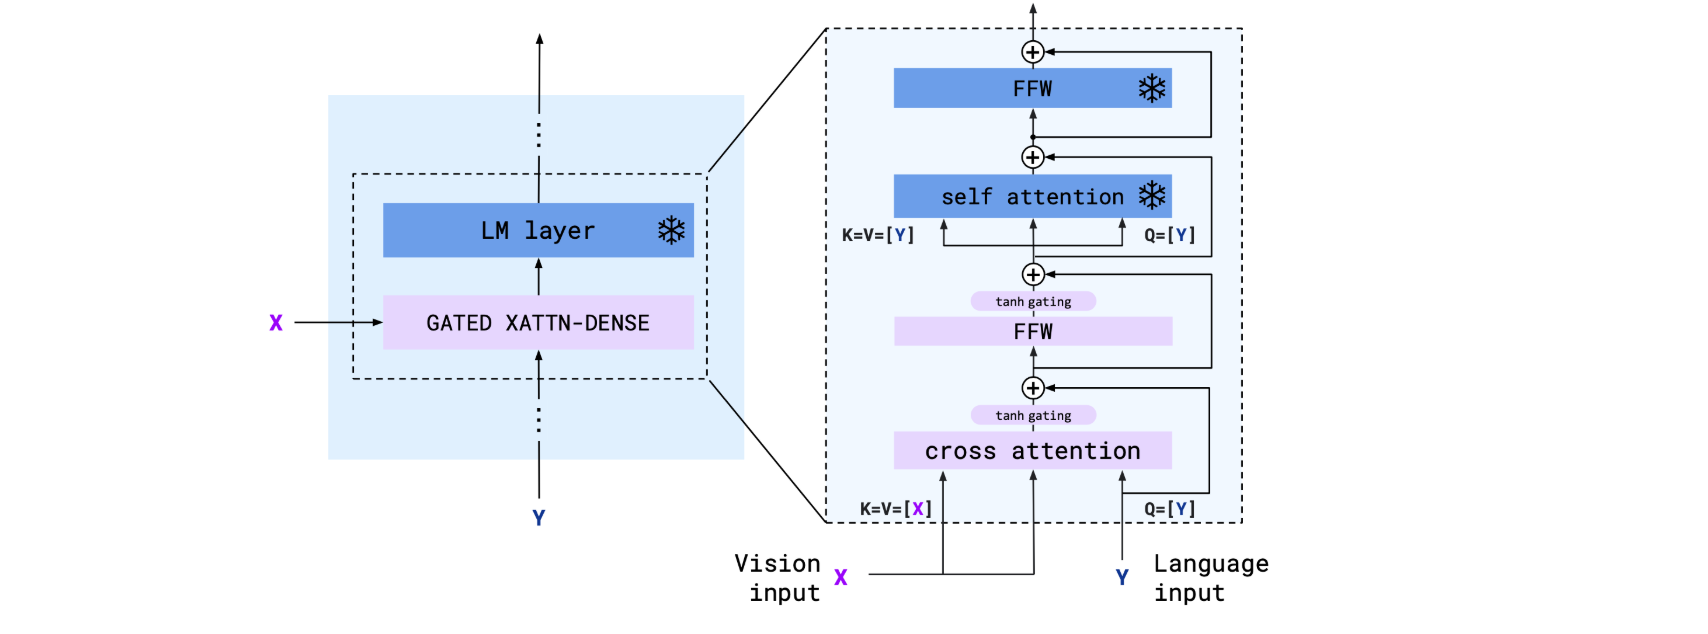

In [ ]:
'''
open_flamingo/src/factory.py
'''

def extend_instance(obj, mixin):
    """Apply mixins to a class instance after creation"""
    base_cls = obj.__class__
    base_cls_name = obj.__class__.__name__
    obj.__class__ = type(
        base_cls_name, (mixin, base_cls), {}
    )  # mixin needs to go first for our forward() logic to work (MRO [method resolution order] in Python)


model = Flamingo(
    vision_encoder,   # CLIP
    lang_encoder,     # RedPajama
    text_tokenizer.encode("<|endofchunk|>")[-1],
    text_tokenizer.encode("<image>")[-1],
    vis_dim=open_clip.get_model_config(clip_vision_encoder_path)["vision_cfg"][   # vis_dim = 1024 (CLIP embedding size)
        "width"
    ],
    cross_attn_every_n_layers=cross_attn_every_n_layers,
    **flamingo_kwargs,
)

# convert LM to FlamingoLM
extend_instance(lang_encoder, FlamingoLMMixin) # upgrade our Flamingo!

In [ ]:
import torch.nn as nn
from .helpers import GatedCrossAttentionBlock
from .utils import getattr_recursive, setattr_recursive

'''
open_flamingo/src/flamingo_lm.py
'''


class FlamingoLMMixin(nn.Module):
    """
    Mixin to add cross-attention layers to a language model.
    """

    def set_decoder_layers_attr_name(self, decoder_layers_attr_name):
        self.decoder_layers_attr_name = decoder_layers_attr_name

    def _get_decoder_layers(self):
        return getattr_recursive(self, self.decoder_layers_attr_name)

    def _set_decoder_layers(self, value):
        setattr_recursive(self, self.decoder_layers_attr_name, value)

    def init_flamingo(
        self,
        media_token_id,
        lang_hidden_size,
        vis_hidden_size,
        cross_attn_every_n_layers,
        gradient_checkpointing,
    ):
        """
        Initialize Flamingo by adding a new gated cross attn to the decoder. Store the media token id for computing the media locations.
        """
        self.old_decoder_blocks = self._get_decoder_layers()
        self.gated_cross_attn_layers = nn.ModuleList(
            [
                GatedCrossAttentionBlock(
                    dim=lang_hidden_size, dim_visual=vis_hidden_size
                )
                if (layer_idx + 1) % cross_attn_every_n_layers == 0
                else None
                for layer_idx, _ in enumerate(self._get_decoder_layers())
            ]
        )
        self.init_flamingo_layers(gradient_checkpointing)
        self.media_token_id = media_token_id
        self.initialized_flamingo = True
        self._use_cached_vision_x = False

    def init_flamingo_layers(self, gradient_checkpointing):
        """
        Initializes the FlamingoLayers.
        Propagates any changes made to self.gated_corss_attn_layers or self.old_decoder_blocks
        """
        self._set_decoder_layers(
            nn.ModuleList(
                [
                    FlamingoLayer(
                        gated_cross_attn_layer, decoder_layer, gradient_checkpointing
                    )
                    for gated_cross_attn_layer, decoder_layer in zip(
                        self.gated_cross_attn_layers, self.old_decoder_blocks
                    )
                ]
            )
        )



class FlamingoLayer(nn.Module):
    """
    FlamingoLayer is a wrapper around the GatedCrossAttentionBlock and DecoderLayer.
    """

    def __init__(
        self, gated_cross_attn_layer, decoder_layer, gradient_checkpointing=False
    ):
        super().__init__()
        self.gated_cross_attn_layer = gated_cross_attn_layer
        self.decoder_layer = decoder_layer
        self.vis_x = None
        self.media_locations = None
        if self.gated_cross_attn_layer is not None:
            self.gated_cross_attn_layer._use_gradient_checkpointing = (
                gradient_checkpointing
            )
        self.decoder_layer._use_gradient_checkpointing = gradient_checkpointing

    def is_conditioned(self) -> bool:
        """Check whether the layer is conditioned."""
        return self.vis_x is not None and self.media_locations is not None

    # Used this great idea from this implementation of Flamingo (https://github.com/dhansmair/flamingo-mini/)
    def condition_vis_x(self, vis_x):
        self.vis_x = vis_x

    def condition_media_locations(self, media_locations):
        self.media_locations = media_locations

    def condition_use_cached_media(self, use_cached_media):
        self.use_cached_media = use_cached_media

    def forward(
        self,
        lang_x,
        attention_mask=None,
        **decoder_layer_kwargs,
    ):
        # Cross attention
        if self.gated_cross_attn_layer is not None:
            if self.vis_x is None:
                raise ValueError("vis_x must be conditioned before forward pass")

            if self.media_locations is None:
                raise ValueError(
                    "media_locations must be conditioned before forward pass"
                )

            lang_x = self.gated_cross_attn_layer(
                lang_x,
                self.vis_x,
                media_locations=self.media_locations,
                use_cached_media=self.use_cached_media,
            )

        # Normal decoder layer
        lang_x = self.decoder_layer(
            lang_x, attention_mask=attention_mask, **decoder_layer_kwargs
        )
        return lang_x

In [ ]:
class GatedCrossAttentionBlock(nn.Module):
    def __init__(
        self,
        *,
        dim,    # language dimension
        dim_visual,   # visual features dimension
        dim_head=64,
        heads=8,
        ff_mult=4,
        only_attend_immediate_media=True,
    ):
        super().__init__()
        self.attn = MaskedCrossAttention(
            dim=dim,
            dim_visual=dim_visual,
            dim_head=dim_head,
            heads=heads,
            only_attend_immediate_media=only_attend_immediate_media,
        )
        self.attn_gate = nn.Parameter(torch.tensor([0.0]))

        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.0]))

    def forward(
        self,
        x,
        media,
        media_locations=None,
        use_cached_media=False,
    ):
        x = (
            self.attn(
                x,
                media,
                media_locations=media_locations,
                use_cached_media=use_cached_media,
            )
            * self.attn_gate.tanh()
            + x
        )
        x = self.ff(x) * self.ff_gate.tanh() + x

        return x

### 1.2. Deep Fusion: Custom layer (CLDF)


#### **MoE-LLaVA** ([GitHub](https://github.com/PKU-YuanGroup/MoE-LLaVA), [Paper](https://arxiv.org/abs/2401.15947))

MoE-LLaVA demonstrates the ability to detect and answer challenging questions whenprompted to verify them.

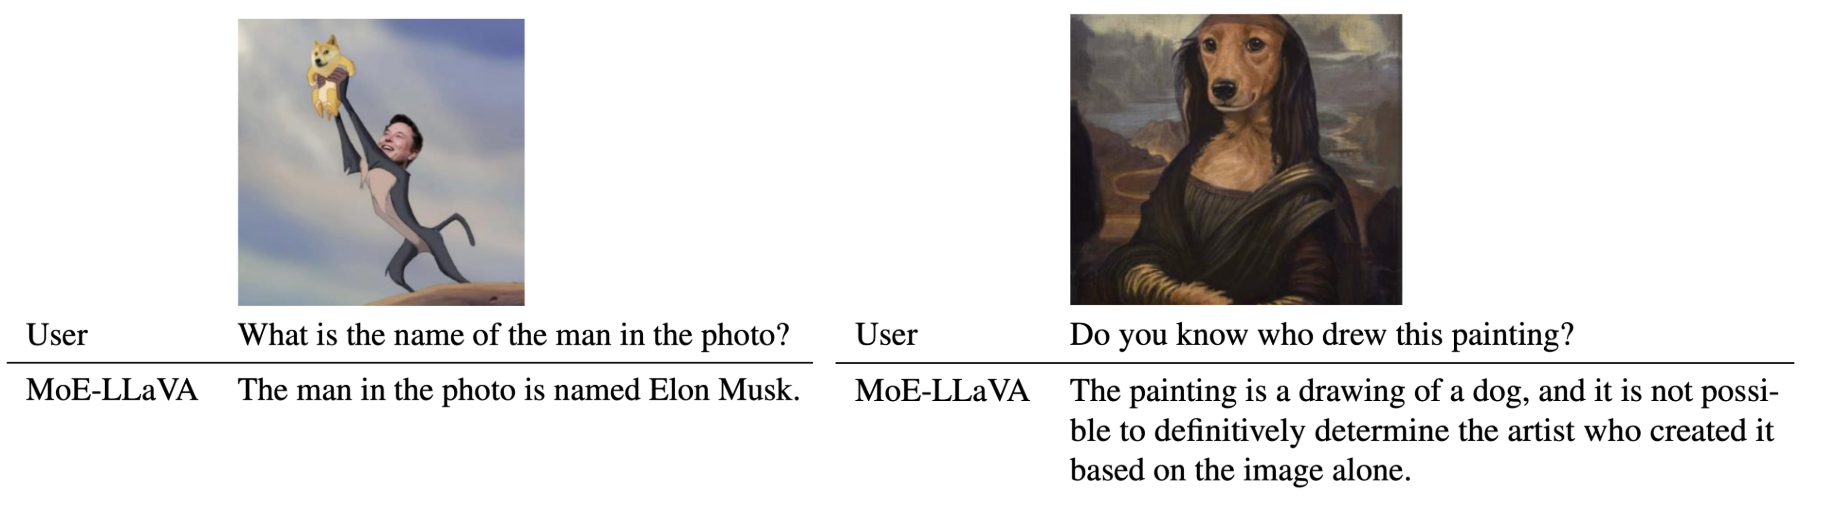

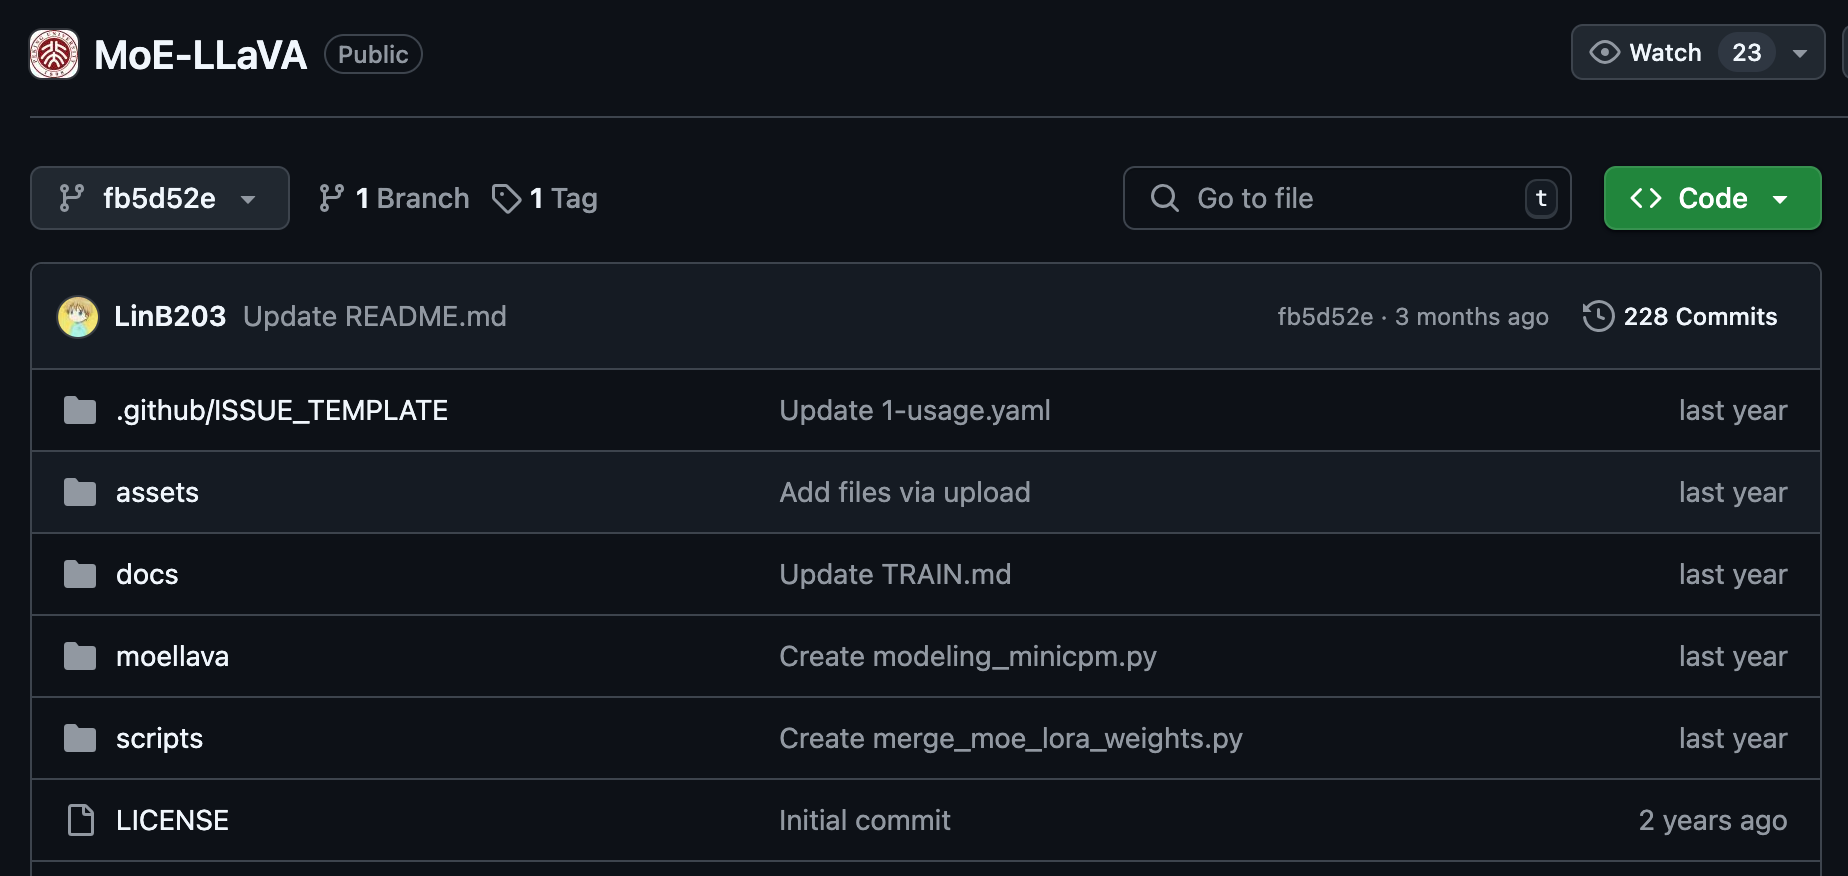

In [ ]:
'''
MoE-LLaVA/moellava/train/train.py
'''

model = MoELLaVALlamaForCausalLM.from_pretrained(
    'liuhaotian/llava-v1.5-7b',
    cache_dir=training_args.cache_dir,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    'liuhaotian/llava-v1.5-7b',
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length,
    padding_side="right",
    use_fast=False,
)

tokenizer.pad_token = tokenizer.unk_token
model.config.pad_token_id = tokenizer.pad_token_id

conversation_lib.default_conversation = conversation_lib.conv_templates[model_args.version]   # system prompt

 model.get_model().initialize_vision_modules(
    model_args=model_args,
    fsdp=training_args.fsdp
)

##### **Vision Encoder** (MLP)

In [ ]:
'''
MoE-LLaVA/moellava/model/multimodal_encoder/clip_encoder.py
'''

import torch
import torch.nn as nn

from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig


class CLIPVisionTower(nn.Module):
    def __init__(self, image_tower, args, delay_load=False, cache_dir='./cache_dir'):
        super().__init__()

        self.is_loaded = False

        self.image_tower_name = image_tower
        self.select_layer = args.mm_vision_select_layer
        self.select_feature = getattr(args, 'mm_vision_select_feature', 'patch')

        self.cache_dir = cache_dir

        if not delay_load:
            self.load_model()
        else:
            self.cfg_only = CLIPVisionConfig.from_pretrained(self.image_tower_name, cache_dir=self.cache_dir)

    def load_model(self):
        self.image_processor = CLIPImageProcessor.from_pretrained(self.image_tower_name, cache_dir=self.cache_dir)
        self.image_tower = CLIPVisionModel.from_pretrained(self.image_tower_name, cache_dir=self.cache_dir)
        self.image_tower.requires_grad_(False)

        self.is_loaded = True

    def feature_select(self, image_forward_outs):
        image_features = image_forward_outs.hidden_states[self.select_layer]
        if self.select_feature == 'patch':
            image_features = image_features[:, 1:]
        elif self.select_feature == 'cls_patch':
            image_features = image_features
        else:
            raise ValueError(f'Unexpected select feature: {self.select_feature}')
        return image_features

    @torch.no_grad()
    def forward(self, images):
        if type(images) is list:
            image_features = []
            for image in images:
                image_forward_out = self.image_tower(image.to(device=self.device, dtype=self.dtype).unsqueeze(0), output_hidden_states=True)
                image_feature = self.feature_select(image_forward_out).to(image.dtype)
                image_features.append(image_feature)
        else:
            image_forward_outs = self.image_tower(images.to(device=self.device, dtype=self.dtype), output_hidden_states=True)   # (c, h, w) -> (v, d)
            image_features = self.feature_select(image_forward_outs).to(images.dtype)  # leave 256 tokens

        return image_features

    @property
    def dummy_feature(self):
        return torch.zeros(1, self.hidden_size, device=self.device, dtype=self.dtype)

    @property
    def dtype(self):
        return self.image_tower.dtype

    @property
    def device(self):
        return self.image_tower.device

    @property
    def config(self):
        if self.is_loaded:
            return self.image_tower.config
        else:
            return self.cfg_only

    @property
    def hidden_size(self):
        return self.config.hidden_size

    @property
    def num_patches(self):
        return (self.config.image_size // self.config.patch_size) ** 2

##### **Feature Fusion:** Mixture-of-Experts layer

Initialization of MoE layer in MoE-LLaVA class

In [ ]:
from deepspeed.moe.layer import MoE


class MoELLaVALlamaForCausalLM(LlamaForCausalLM, LlavaMetaForCausalLM):
    config_class = MoELLaVALlamaConfig

    def __init__(self, config):
        super(LlamaForCausalLM, self).__init__(config)
        self.model = MoELLaVALlamaModel(config)
        self.pretraining_tp = config.pretraining_tp
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_model(self):
        return self.model


    def initialize_moe_modules(self, model_args):
        num_layers = self.config.num_hidden_layers

        moe_layers_idx = model_args.moe_layers_idx
        if model_args.moe_layers_idx is not None:
            model_args.moe_mode = 'custom'
            assert len(model_args.moe_layers_idx) <= num_layers
            assert max(model_args.moe_layers_idx) < num_layers
            assert min(model_args.moe_layers_idx) >= 0
        else:
            if model_args.moe_mode == "first_half":
                moe_layers_idx = list(range(0, num_layers // 2))
            elif model_args.moe_mode == "second_half":
                moe_layers_idx = list(range(num_layers // 2, num_layers))
            elif model_args.moe_mode == "sparse":
                moe_layers_idx = list(range(num_layers))[::2]
            elif model_args.moe_mode == "dense":
                moe_layers_idx = list(range(num_layers))
            else:
                raise NotImplementedError(
                    f'Only support ["first_half", "second_half", "sparse", "dense"], but found {model_args.moe_mode}')

        self.config.moe['moe_layers_idx'] = moe_layers_idx
        if len(model_args.num_experts) == 1:
            self.config.moe['num_experts'] = model_args.num_experts * len(moe_layers_idx)
        assert len(self.config.moe['num_experts']) == len(moe_layers_idx)

        for num_experts, layer_num in zip(self.config.moe['num_experts'], moe_layers_idx):    # if we have experts, initialize
            pretrained_state_dict = self.model.layers[layer_num].mlp.state_dict()
            self.model.layers[layer_num].mlp = MoE(     # initialization of MoE layers
                self.config.hidden_size,
                expert=self.model.layers[layer_num].mlp,
                num_experts=num_experts,
                ep_size=model_args.ep_size,
                k=model_args.top_k_experts,
                capacity_factor=model_args.capacity_factor,
                eval_capacity_factor=model_args.eval_capacity_factor,
                min_capacity=model_args.min_capacity,
                use_residual=model_args.use_residual,
            )
            for e in self.model.layers[layer_num].mlp.deepspeed_moe.experts.deepspeed_experts:  # check weight
                loaded_state_dict = e.state_dict()
                assert all([torch.allclose(pretrained_state_dict[k], v) for k, v in loaded_state_dict.items()])
                assert all([torch.allclose(loaded_state_dict[k], v) for k, v in pretrained_state_dict.items()])

        for m in self.model.layers:
            m.forward = MoELlamaDecoderLayer_forward(m)
        rank0_print(f'replace LlamaDecoderLayer.forward to MoELlamaDecoderLayer.forward')
        self.model.forward = MoELlamaModel_forward(self.model)
        rank0_print(f'replace LlamaModel.forward to MoELlamaModel.forward')

MoE layer details

In [ ]:
self.feed_forward = MoeLayer(
    experts=[FeedForward(dim=dim, hidden_dim=hidden_dim, lora=lora) for _ in range(moe.num_experts)],
    gate=nn.Linear(dim, moe.num_experts, bias=False),
    moe_args=moe,
)

In [ ]:
import dataclasses
from typing import List

import torch
import torch.nn.functional as F
from simple_parsing.helpers import Serializable
from torch import nn


@dataclasses.dataclass
class MoeArgs(Serializable):
    num_experts: int
    num_experts_per_tok: int


class MoeLayer(nn.Module):
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoeArgs):
        super().__init__()
        assert len(experts) > 0
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        gate_logits = self.gate(inputs)
        weights, selected_experts = torch.topk(gate_logits, self.args.num_experts_per_tok)  # each token is processed by the top-k experts with the highest probabilities
        weights = F.softmax(weights, dim=1, dtype=torch.float).to(inputs.dtype)
        results = torch.zeros_like(inputs)
        for i, expert in enumerate(self.experts):
            batch_idx, nth_expert = torch.where(selected_experts == i)
            results[batch_idx] += weights[batch_idx, nth_expert, None] * expert(inputs[batch_idx])
        return results